In [11]:
import numpy as np
from scipy.stats import norm
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from numerical_routine import *
from scipy.stats import norm
from ebnm_point_exp import *
import numpy as np

In [14]:
true_val1=  np.random.normal(loc=0, scale=1, size=100)
true_val0=  np.zeros( 200)

observations_mu_1 =true_val1+np.random.normal(loc=0, scale=1, size=100)
observations_mu_0 =true_val0+ np.random.normal(loc=0, scale=1, size=200)
# Combine them into one array
betahat = np.hstack([observations_mu_1, observations_mu_0])
sebetahat=  np.repeat(1, betahat.shape[0])
res=ebnnm_point_exp_solver(x=betahat, s=sebetahat)
 

np.float64(1.2982569263385153)

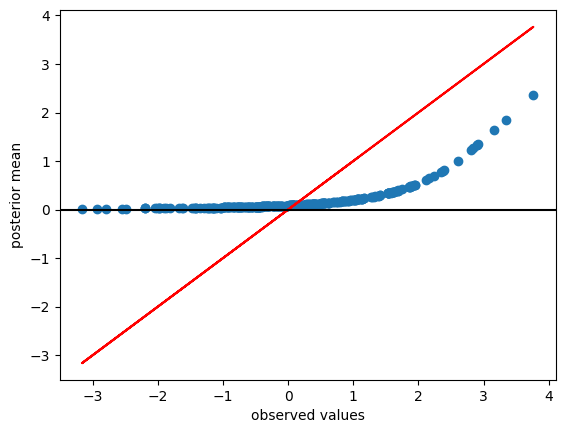

In [15]:
plt.scatter(betahat, res.post_mean  )
plt.xlabel("observed values")
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")
res.scale

In [27]:
from scipy.stats import norm
import numpy as np

def wpost_pe(x, s, w, a):
    """
    Compute the posterior weights for the exponential component under a point-exponential prior.

    Args:
        x (np.ndarray): Input data.
        s (np.ndarray or float): Standard deviations.
        w (float): Mixture weight for the exponential component.
        a (float): Scale parameter for the exponential component.

    Returns:
        np.ndarray: Posterior weights for the exponential component.
    """
    if w == 0:
        return np.zeros_like(x)

    if w == 1:
        return np.ones_like(x)

    # Log-density for the normal (point mass) component
    lf = norm.logpdf(x, loc=0, scale=s)

    # Log-density for the exponential component
    lg = np.log(a) + s**2 * a**2 / 2 - a * x + norm.logcdf(x / s - s * a)

    # Compute posterior weights
    wpost = w / (w + (1 - w) * np.exp(lf - lg))

    return wpost


In [28]:
x = np.array([1.0, 2.0, -1.5])
s = np.array([1.0, 1.2, .5])
wpost_pe(x,s,0.5,1)

array([0.55620924, 0.69507278, 0.11760856])

In [29]:
class PosteriorMeanPointExp:
    def __init__(self, post_mean, post_mean2, post_sd):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd

def posterior_mean_pe(x, s, w, a, mu=0):
    """
    Compute the posterior mean for a normal mean under a Laplace prior.
    
    Args:
        x (np.ndarray): Observed data.
        s (float or np.ndarray): Standard deviation of the normal likelihood.
        w (float): Mixture weight for the Laplace component.
        a (float): Laplace scale parameter.
        mu (float): Mean of the prior distribution (default is 0).
    
    Returns:
        np.ndarray: Posterior means.
    """
    # Compute posterior weights
    wpost = wpost_pe(x - mu, s, w, a)
     
    
    # Compute the truncated means for the Laplace component
    laplace_mean_positive = my_etruncnorm(0, 99999 ,x - mu - s**2 * a, s) 
    laplace_component_mean =   laplace_mean_positive  
    post_mean2              =  wpost * (  my_e2truncnorm(0, np.inf, x - mu - s**2 * a, s)
                                       )

    
    # Combine posterior means
    post_mean =    wpost * laplace_component_mean  

    if np.any(np.isinf(s)):
        inf_indices = np.isinf(s)
        a = 1/scale[1:]
        # Equivalent of `post$mean[is.infinite(s)]` 
        post_mean[inf_indices] = wpost  / a 

        # Equivalent of `post$mean2[is.infinite(s)]`
        post_mean2[inf_indices] =  2 * wpost / a**2 

    post_mean2 = np.maximum(post_mean2, post_mean  ** 2)
    
    post_sd= np.sqrt(np.maximum(0, post_mean2 - post_mean**2))
    post_mean2 = post_mean2 + mu**2+ 2*mu*post_mean
    post_mean  =  post_mean+mu  
    return PosteriorMeanPointExp(post_mean=post_mean,
                                     post_mean2=post_mean2,
                                     post_sd=  post_sd)



x = np.array([1.0, 2.0, -1.5])
s = np.array([1.0, 1.2, 2.5])
a= posterior_mean_pe(x,s,w=.7 ,a=1, mu=0 ) 
print(a.post_sd)
print(a.post_mean)

[0.62583508 0.8761269  0.61477198]
[0.59457077 1.00312451 0.4373592 ]


In [30]:
import numpy as np
from scipy.stats import norm

def logscale_add(logx, logy):
    """
    Compute log(exp(logx) + exp(logy)) in a numerically stable way.
    """
    max_log = np.maximum(logx, logy)
    return max_log + np.log(np.exp(logx - max_log) + np.exp(logy - max_log))

def pe_nllik(par, x, s, par_init, fix_par, calc_grad=False, calc_hess=False):
    """
    Compute the negative log likelihood, gradient, and Hessian for the point-exponential prior.

    Args:
        par (list): Parameters to optimize (subset based on fix_par).
        x (np.ndarray): Observed data.
        s (np.ndarray): Standard deviations.
        par_init (list): Initial parameters (full set).
        fix_par (list): Boolean list indicating which parameters are fixed.
        calc_grad (bool): Whether to calculate the gradient.
        calc_hess (bool): Whether to calculate the Hessian.

    Returns:
        float: Negative log likelihood.
        Optional: Gradient and Hessian as attributes of the output.
    """
    fix_pi0, fix_a, fix_mu = fix_par

    # Initialize parameters and update non-fixed values
    p = np.array(par_init)
    p[~np.array(fix_par)] = par

    # Parameters
    w = 1 - 1 / (1 + np.exp(p[0]))  # Transformation for w
    a = np.exp(p[1])               # Transformation for a
    mu = p[2]                      # mu

    # Point mass component
    lf = -0.5 * np.log(2 * np.pi * s**2) - 0.5 * ((x - mu) / s)**2

    # Exponential component
    xright = (x - mu) / s - s * a
    lpnormright = norm.logcdf(xright)
    lg = np.log(a) + s**2 * a**2 / 2 - a * (x - mu) + lpnormright

    # Combine log likelihood components
    llik = logscale_add(np.log(1 - w) + lf, np.log(w) + lg)
    nllik = -np.sum(llik)

    # Gradients (optional)
    if calc_grad or calc_hess:
        grad = np.zeros(len(par))
        i = 0

        # Gradient with respect to w (alpha)
        if not fix_pi0:
            f = np.exp(lf - llik)
            g = np.exp(lg - llik)
            dnllik_dw = f - g
            dw_dalpha = w * (1 - w)
            grad[i] = np.sum(dnllik_dw * dw_dalpha)
            i += 1

        # Gradient with respect to a (beta)
        if not fix_a or not fix_mu:
            dlogpnorm_right = np.exp(-0.5 * np.log(2 * np.pi) - 0.5 * xright**2 - lpnormright)

        if not fix_a:
            dg_da = np.exp(lg - llik) * (1 / a + a * s**2 - (x - mu) - s * dlogpnorm_right)
            dnllik_da = -w * dg_da
            da_dbeta = a
            grad[i] = np.sum(dnllik_da * da_dbeta)
            i += 1

        # Gradient with respect to mu
        if not fix_mu:
            df_dmu = np.exp(lf - llik) * ((x - mu) / s**2)
            dg_dmu = np.exp(lg - llik) * (a - dlogpnorm_right / s)
            dnllik_dmu = -(1 - w) * df_dmu - w * dg_dmu
            grad[i] = np.sum(dnllik_dmu)

    # Hessian (optional)
    if calc_hess:
        hess = np.zeros((len(par), len(par)))
        i = 0

        # Hessian with respect to w (alpha)
        if not fix_pi0:
            d2nllik_dw2 = dnllik_dw**2
            d2w_dalpha2 = (1 - 2 * w) * dw_dalpha
            d2nllik_dalpha2 = d2nllik_dw2 * (dw_dalpha**2) + dnllik_dw * d2w_dalpha2
            hess[i, i] = np.sum(d2nllik_dalpha2)

            j = i + 1
            if not fix_a:
                d2nllik_dwda = dnllik_dw * dnllik_da - dg_da
                d2nllik_dalphadbeta = d2nllik_dwda * dw_dalpha * da_dbeta
                hess[i, j] = hess[j, i] = np.sum(d2nllik_dalphadbeta)
                j += 1

            if not fix_mu:
                d2nllik_dwdmu = dnllik_dw * dnllik_dmu - (dg_dmu - df_dmu)
                d2nllik_dalphadmu = d2nllik_dwdmu * dw_dalpha
                hess[i, j] = hess[j, i] = np.sum(d2nllik_dalphadmu)

            i += 1

        # Hessian with respect to a (beta)
        if not fix_a:
            d2g_da2 = dg_da * (1 / a + a * s**2 - (x - mu) - s * dlogpnorm_right) + \
                      np.exp(lg - llik) * (-1 / a**2 + s**2 * (1 - dlogpnorm_right * xright - dlogpnorm_right**2))
            d2nllik_da2 = dnllik_da**2 - w * d2g_da2
            d2a_dbeta2 = da_dbeta
            d2nllik_dbeta2 = d2nllik_da2 * (da_dbeta**2) + dnllik_da * d2a_dbeta2
            hess[i, i] = np.sum(d2nllik_dbeta2)

            j = i + 1
            if not fix_mu:
                d2g_dadmu = dg_da * (a - dlogpnorm_right / s) + \
                            np.exp(lg - llik) * (1 - dlogpnorm_right * xright - dlogpnorm_right**2)
                d2nllik_dbetadmu = dnllik_dbeta * dnllik_dmu - w * d2g_dadmu * da_dbeta
                hess[i, j] = hess[j, i] = np.sum(d2nllik_dbetadmu)

            i += 1

        # Hessian with respect to mu
        if not fix_mu:
            d2f_dmu2 = df_dmu * ((x - mu) / s**2) - np.exp(lf - llik) / s**2
            d2g_dmu2 = dg_dmu * (a - dlogpnorm_right / s) - \
                       np.exp(lg - llik) * (dlogpnorm_right * xright + dlogpnorm_right**2) / s**2
            d2nllik_dmu2 = dnllik_dmu**2 - (1 - w) * d2f_dmu2 - w * d2g_dmu2
            hess[i, i] = np.sum(d2nllik_dmu2)

    if calc_grad and calc_hess:
        return nllik, grad, hess
    elif calc_grad:
        return nllik, grad
    else:
        return nllik


In [31]:
x = np.array([1.0, 2.0, -1.5])  # Observed data
s = np.array([1.0, 1.0, 1.0])   # Standard deviations
par_init = [0.0, 0.0, 0.0]      # Initial parameters (alpha, beta, mu)
fix_par = [False, False, False] # No fixed parameters
par = [0.5, 0.1, 1.0]           # Parameters to optimize

# Compute negative log likelihood
nllik = pe_nllik(par, x, s, par_init, fix_par, calc_grad=False)
print("Negative Log Likelihood:", nllik)


Negative Log Likelihood: 7.026976565768523


In [32]:
from scipy.optimize import minimize

class optimizePointExponential:
    def __init__(self, w, a, mu, nllik):
        self.w = w
        self.a = a
        self.mu = mu
        self.nllik = nllik

def optimize_pe_nllik_with_gradient(x, s, par_init, fix_par):
    """
    Optimize the negative log likelihood for the point-exponential prior using gradient.

    Args:
        x (np.ndarray): Observed data.
        s (np.ndarray): Standard deviations.
        par_init (list): Initial parameters [alpha, beta, mu].
        fix_par (list): Boolean list indicating which parameters are fixed.

    Returns:
        optimizePointExponential: Optimized parameters and final negative log likelihood.
    """
    # Define a wrapper for the objective function
    def objective(par):
        nllik, grad = pe_nllik(par, x, s, par_init, fix_par, calc_grad=True, calc_hess=False)
        return nllik, grad

    # Wrapper for gradient extraction
    def fun(par):
        nllik, _ = objective(par)
        return nllik

    def jac(par):
        _, grad = objective(par)
        return grad

    # Initial values for non-fixed parameters
    free_params = [p for p, fixed in zip(par_init, fix_par) if not fixed]

    # Bounds: Keep alpha unbounded, beta > 0, and mu unbounded
    bounds = [
        (None, None),  # Alpha has no bounds
        (0, None),     # Beta must be strictly positive
        (None, None)   # Mu has no bounds
    ]
    bounds = [b for b, fixed in zip(bounds, fix_par) if not fixed]

    # Optimize using L-BFGS-B
    result = minimize(
        fun, free_params, method="L-BFGS-B", jac=jac, bounds=bounds
    )

    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    # Update the full parameter set with optimized values
    optimized_params = np.array(par_init)
    optimized_params[~np.array(fix_par)] = result.x

    # Convert alpha to w
    optimized_params[0] = 1 - 1 / (1 + np.exp(optimized_params[0]))

    # Convert beta to a
    optimized_params[1] = np.exp(optimized_params[1])

    return optimizePointExponential(w=optimized_params[0],
                                     a=optimized_params[1],
                                     mu=optimized_params[2],
                                     nllik=result.fun)

# Example Usage
x = np.array([1.0, 1.0, -0.5])  # Observed data
s = np.array([1.0, 1.0, 1.0])   # Standard deviations
par_init = [0.0, 0.1, 0.0]      # Initial parameters [alpha, beta, mu]
fix_par = [False, False, True] # No fixed parameters

# Run optimization
result = optimize_pe_nllik_with_gradient(x, s, par_init, fix_par)
print("Final Negative Log Likelihood:", result.nllik)
print("Optimized w:", result.w)
print("Optimized a:", result.a)
print("Optimized mu:", result.mu)


Final Negative Log Likelihood: 3.6365536321320833
Optimized w: 0.9999563044116644
Optimized a: 3.047337093696008
Optimized mu: 0.0


In [6]:
class ebnm_point_exp:
    def __init__(self, post_mean, post_mean2, post_sd, scale, pi,   log_lik=0,#log_lik2 =0,
                 mode=0):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.scale= scale
        self.pi =pi  
        self.log_lik = log_lik
       # self.log_lik2= log_lik2 
        self.mode =  mode


def ebnm_point_exp_solver ( x,s,opt_mu=False,par_init = [0.0, 1.0, 0.0]  ):
    if(opt_mu):
        fix_par = [False, False, False]
    else :
        fix_par = [False, False, True]
    par_init = par_init
    optimized_prior =  optimize_pe_nllik_with_gradient(x, s, par_init, fix_par)
    post_obj=  posterior_mean_pe(x, s, optimized_prior.w, optimized_prior.a, optimized_prior.mu)
    return( ebnnm_point_exp( post_mean=post_obj.post_mean, 
                                post_mean2=post_obj.post_mean2, 
                                post_sd=post_obj.post_sd,
                                scale=optimized_prior.a,
                                pi=optimized_prior.w,   log_lik=-optimized_prior.nllik,#log_lik2 =0,
                                mode=optimized_prior.mu)
    )

In [9]:
true_val1=  np.random.normal(loc=0, scale=1, size=100)
true_val0=  np.zeros( 100)

observations_mu_1 =true_val1+np.random.normal(loc=0, scale=1, size=100)
observations_mu_0 =true_val0+ np.random.normal(loc=0, scale=1, size=100)
# Combine them into one array
betahat = np.hstack([observations_mu_1, observations_mu_0])
sebetahat=  np.repeat(1, betahat.shape[0])
res= ebnm_point_exp_solver(x=betahat, s=sebetahat)
 

np.float64(1.3579529250729996)

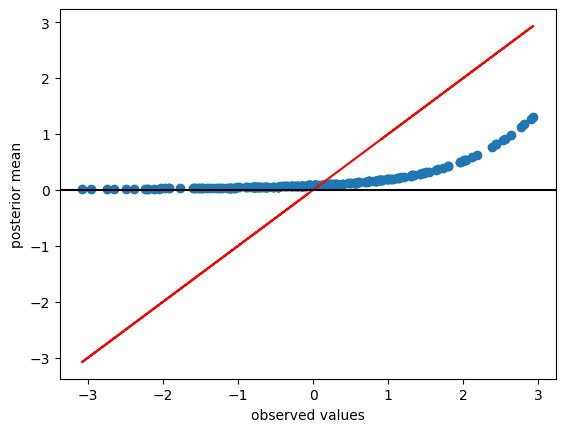

In [10]:
plt.scatter(betahat, res.post_mean  )
plt.xlabel("observed values")
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")
res.scale